In [1]:
import networkx as nx

import matplotlib.pyplot as plt
import random
import json
import community as community_louvain

import numpy as np

import numpy as np
from scipy.sparse import csr_matrix

# 设置随机种子
random.seed(42)
np.random.seed(42)
from networkx.algorithms.community import girvan_newman

In [3]:
def read_directed_graph(file_path, skip_lines):
    G = nx.DiGraph()  # Initialize an empty directed graph
    with open(file_path, 'r') as file:
        for _ in range(skip_lines):
            next(file)  # Skip the initial descriptive lines
        for line in file:
            parts = line.strip().split()
            if len(parts) == 2:  # Only consider lines with exactly two node identifiers
                u, v = parts
                G.add_edge(u, v)
    
    return G


path = '/Users/ernest/Desktop/comp8880/project/code 2/data/soc/soc-Slashdot0811.txt'
G = read_directed_graph(path,3)
G.remove_edges_from(nx.selfloop_edges(G))


In [4]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges

(77360, 828161)

In [5]:
with open('saved/network_metrics_slash.json', 'r') as f:
    loaded_data = json.load(f)

# 访问加载的数据
sorted_centrality = loaded_data["Centrality"]
sorted_pagerank =  loaded_data["PageRank"]
sorted_leaderRank =  loaded_data["LeaderRank"]
sorted_hIndex =  loaded_data["HIndex"]
sorted_kShell=  loaded_data["KShell"]
# 更多的访问可以根据需要添加


In [7]:

print(sorted_centrality[:3])
print(sorted_pagerank[:3])
print(sorted_leaderRank[:3])
print(sorted_hIndex[:3])
print(sorted_kShell[:3])


[['2481', 0.06522835093524994], ['394', 0.05848059049367236], ['4675', 0.05749815793895991]]
[['2481', 0.0029730052356006587], ['394', 0.0026745576707996746], ['34', 0.002341799463228293]]
[['2481', 0.0021783055563750196], ['34', 0.0020590574294100297], ['377', 0.0019739963840719587]]
[['4675', 267], ['46', 254], ['192', 241]]
[['8', 106], ['46', 106], ['83', 106]]


In [8]:
import networkx as nx
import community as community_louvain
import numpy as np

def detect_communities(G):
    """使用Louvain算法检测社区"""
    partition = community_louvain.best_partition(G)
    return partition

def community_aware_ranking_sorted(centrality, partition, budget, alpha=2.2):
    """
    基于已排序的中心性数据进行社区感知排名
    :param centrality: 中心性度量（字典）
    :param partition: 社区划分（字典）
    :param budget: 选择的节点数
    :param alpha: 幂函数分配的参数
    :return: 排名前budget的节点列表
    """
    # 将节点按社区划分
    community_nodes = {}
    for node, community in partition.items():
        if community not in community_nodes:
            community_nodes[community] = []
        community_nodes[community].append(node)

    # 社区内对节点按中心性排序
    for community in community_nodes:
        community_nodes[community].sort(key=lambda node: centrality[node], reverse=True)

    # 计算每个社区的重要性（基于中心性总和）
    community_importance = {}
    for community, nodes in community_nodes.items():
        community_importance[community] = sum(centrality[node] for node in nodes)

    # 总重要性
    total_importance = sum(community_importance.values())

    # 根据社区重要性使用幂函数分配节点名额
    community_budget = {}
    for community, importance in community_importance.items():
        share = (importance / total_importance) ** alpha
        community_budget[community] = int(np.floor(share * budget))

    # 调整总名额分配，确保总数为budget
    total_allocated = sum(community_budget.values())
    while total_allocated != budget:
        for community in community_budget:
            if total_allocated < budget:
                community_budget[community] += 1
                total_allocated += 1
                if total_allocated == budget:
                    break
            elif total_allocated > budget:
                if community_budget[community] > 0:
                    community_budget[community] -= 1
                    total_allocated -= 1
                    if total_allocated == budget:
                        break

    # 选择每个社区中最重要的节点，直到达到预算
    selected_nodes = set()
    for community, nodes in community_nodes.items():
        num_to_select = community_budget[community]
        selected_nodes.update(nodes[:num_to_select])

    return list(selected_nodes)


In [9]:
import networkx as nx
import community as community_louvain
import numpy as np

def detect_communities(G):
    """使用Louvain算法检测社区"""
    partition = community_louvain.best_partition(G)
    return partition

def community_aware_ranking_sorted_2(k_shell, centrality, partition, budget, alpha=2):
    """
    基于已排序的k-shell值进行社区感知排名
    :param k_shell: k-shell值字典
    :param centrality: 中心性度量（字典）
    :param partition: 社区划分（字典）
    :param budget: 选择的节点数
    :param alpha: 幂函数分配的参数
    :return: 排名前budget的节点列表
    """
    # 将节点按社区划分
    community_nodes = {}
    for node, community in partition.items():
        if community not in community_nodes:
            community_nodes[community] = []
        community_nodes[community].append(node)

    # 社区内对节点按k-shell值排序
    for community in community_nodes:
        community_nodes[community].sort(key=lambda node: centrality[node], reverse=True)

    # 计算每个社区的重要性（基于k-shell值总和）
    community_importance = {}
    for community, nodes in community_nodes.items():
        community_importance[community] = sum(k_shell[node] for node in nodes)

    # Calculate the mean and standard deviation of community importances
    importances = list(community_importance.values())
    mean_importance = np.mean(importances)
    std_importance = np.std(importances)

    # Standardize the community importances
    standardized_importance = {community: (imp - mean_importance) / std_importance
                               for community, imp in community_importance.items()}

    # 根据社区重要性使用幂函数分配节点名额
    community_budget = {}
    for community, imp in standardized_importance.items():
        if imp < 0:
        # Handle negative importance values if alpha is not an integer
            share = (-imp) ** alpha
        else:
            share = imp ** alpha
        community_budget[community] = max(0, int(np.floor(share * budget)))  # Ensure non-negative allocations

    # Adjust total allocation to ensure total is budget
    total_allocated = sum(community_budget.values())
    while total_allocated != budget:
        for community in community_budget:
            if total_allocated < budget:
                community_budget[community] += 1
                total_allocated += 1
                if total_allocated == budget:
                    break
            elif total_allocated > budget:
                if community_budget[community] > 0:
                    community_budget[community] -= 1
                    total_allocated -= 1
                    if total_allocated == budget:
                        break

    # 选择每个社区中最重要的节点，直到达到预算
    selected_nodes = set()
    for community, nodes in community_nodes.items():
        num_to_select = community_budget[community]
        selected_nodes.update(nodes[:num_to_select])

    return list(selected_nodes)


In [10]:
k_shell = nx.core_number(G)

In [12]:


def leader_rank(G2, damping=0.85, tol=1e-6, max_iter=100):
    # Add the ground node connected to all other nodes
    ground_node = 'ground'
    G = G2.copy()
    G.add_node(ground_node)
    for node in set(G.nodes()) - {ground_node}:
        G.add_edge(ground_node, node)

    # Create a mapping from node to index
    node_list = list(G.nodes())
    node_index = {node: i for i, node in enumerate(node_list)}
    n = len(node_list)
    
    # Initialize scores to 1 for all nodes
    scores = np.ones(n)
    
    # Create adjacency matrix
    row = []
    col = []
    data = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            for neighbor in neighbors:
                row.append(node_index[neighbor])
                col.append(node_index[node])
                data.append(1.0 / len(neighbors))
    
    adjacency_matrix = csr_matrix((data, (row, col)), shape=(n, n))
    
    # Power iteration: iterate until convergence
    for _ in range(max_iter):
        new_scores = adjacency_matrix.dot(scores)
        new_scores[node_index[ground_node]] = np.sum(scores)  # Special handling for the ground node
        if np.linalg.norm(new_scores - scores, 1) < tol:
            scores = new_scores
            break
        scores = new_scores
    
    # Remove the ground node score and normalize the scores
    ground_node_score = scores[node_index[ground_node]]
    total_score = np.sum(scores) - ground_node_score
    scores = (scores - ground_node_score / n) / total_score
    
    # Create the final scores dictionary
    final_scores = {node_list[i]: scores[i] for i in range(n) if node_list[i] != ground_node}
    
    return final_scores





def calculate_h_index(G):
    h_index = {}
    for node in G.nodes():
        degrees = [G.degree(neighbor) for neighbor in G.neighbors(node)]
        degrees.sort(reverse=True)
        h = 0
        for i, degree in enumerate(degrees):
            if degree >= i + 1:
                h = i + 1
            else:
                break
        h_index[node] = h
    return h_index



In [13]:
leaderRank = leader_rank(G)

In [14]:
G_edge = nx.read_edgelist('/Users/ernest/Desktop/comp8880/project/code 2/data/soc/soc-Slashdot0811.txt')  # 加载您的网络数据
partition = detect_communities(G_edge)


In [15]:
centrality = nx.degree_centrality(G)

In [16]:

# 计算并排序度中心性
#degree_centrality = nx.degree_centrality(G)

#leaderRank = leader_rank(G)
# 社区感知排名
budget = 50 # 选择前5个节点
top_nodes_community_aware = community_aware_ranking_sorted_2(centrality,centrality, partition, budget)
print("Top nodes selected by community-aware ranking:", top_nodes_community_aware)

Top nodes selected by community-aware ranking: ['284', '5759', '4755', '381', '5161', '46', '5107', '7669', '1521', '2803', '2470', '5157', '4690', '192', '66', '4963', '6017', '2863', '2836', '5205', '4986', '5000', '6261', '1825', '5057', '3426', '1874', '4694', '6232', '2475', '416', '337', '3450', '263', '5122', '6089', '2366', '5090', '5187', '408', '5900', '2942', '1712', '5691', '6354', '5102', '143', '115', '595', '871']


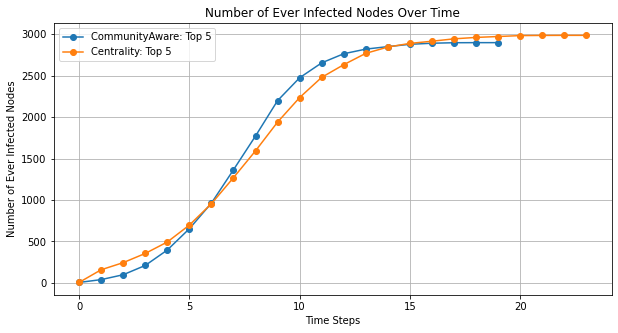

In [19]:

def plot_sir_simulation(G, sorted_maps, top, infection_prob=0.05, steps=100):
    plt.figure(figsize=(10, 5))

    # Calculate average in-degree
    avg_in_degree = sum(dict(G.in_degree()).values()) / G.number_of_nodes()
    #print(avg_in_degree)
    recovery_prob = 1 / avg_in_degree

    # Iterate through all sorted maps
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # Extract top nodes
        history, ever_infected, infected_counts = SIR_simulation(G, top_nodes, infection_prob, 1, steps)
        plt.plot(infected_counts, marker='o', linestyle='-', label=f'{name}: Top {top}')

    plt.title('Number of Ever Infected Nodes Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Ever Infected Nodes')
    plt.grid(True)
    plt.legend()
    plt.show()

def SIR_simulation(G, initial_infected, infection_prob=0.1, recovery_prob=0.05, steps=100):
    # Initialize the status of each node
    status = {node: 'S' for node in G.nodes()}
    for node in initial_infected:
        status[node] = 'I'

    history = []
    ever_infected = set(initial_infected)
    infected_counts = [len(ever_infected)]  # Initial number of infected nodes

    # Simulation process
    for _ in range(steps):
        new_status = status.copy()
        for node in G.nodes():
            if status[node] == 'I':
                for neighbor in G.neighbors(node):
                    if status[neighbor] == 'S' and random.random() < infection_prob:
                        new_status[neighbor] = 'I'
                        ever_infected.add(neighbor)
                if random.random() < recovery_prob:
                    new_status[node] = 'R'
        history.append(new_status)
        status = new_status
        infected_counts.append(len(ever_infected))  # Record the total number of infected nodes

        if not any(s == 'I' for s in status.values()):
            break

    return history, ever_infected, infected_counts

sorted_maps = {
    
    "CommunityAware": [(node, centrality[node]) for node in top_nodes_community_aware],
    "Centrality": sorted_centrality,
    #"PageRank": sorted_pagerank,
    #"LeaderRank": sorted_leaderRank,
    #"H-index": sorted_hIndex,
    #"K-Shell": sorted_kShell
}




# 运行模拟并绘图
plot_sir_simulation(G, sorted_maps,top=5, infection_prob=0.015,steps=50)

In [21]:
# 使用Louvain算法进行社区检测
def detect_communities(G):
    partition = community_louvain.best_partition(G)
    return partition


# 统计前top节点在各社区中的分布
def count_top_nodes_in_communities(G, sorted_maps, top, partition):
    community_counts = {name: {} for name in sorted_maps.keys()}
    
    for name, sorted_map in sorted_maps.items():
        top_nodes = [node for node, _ in sorted_map[:top]]  # 提取前top个节点
        for node in top_nodes:
            community = partition[node]
            if community not in community_counts[name]:
                community_counts[name][community] = 0
            community_counts[name][community] += 1
    
    return community_counts

# 可视化前top节点在各社区中的分布
def plot_top_nodes_distribution(community_counts, top):
    plt.figure(figsize=(15, 10))

    for i, (name, counts) in enumerate(community_counts.items()):
        communities = list(counts.keys())
        counts = list(counts.values())
        
        plt.subplot(3, 3, i + 1)
        plt.bar(communities, counts)
        plt.title(f'Distribution of Top {top} Nodes in Communities\n({name})')
        plt.xlabel('Community')
        plt.ylabel('Number of Top Nodes')

    plt.tight_layout()
    plt.show()

# 统计每个社区的节点数量并排序
def count_and_sort_communities(partition):
    community_counts = {}
    for node, community in partition.items():
        if community not in community_counts:
            community_counts[community] = 0
        community_counts[community] += 1
    
    # 按照节点数量排序社区
    sorted_community_counts = sorted(community_counts.items(), key=lambda x: x[1], reverse=True)
    return sorted_community_counts

In [22]:
# 示例：检测社区并统计前top节点的分布
G_edge = nx.read_edgelist('/Users/ernest/Desktop/comp8880/project/code 2/data/soc/soc-Slashdot0811.txt')  # 加载您的网络数据
partition = detect_communities(G_edge)



In [23]:
partition_file = 'saved/partition_slash.json'
with open(partition_file, 'w') as f:
    json.dump(partition, f)



In [24]:
print(f"Partition saved to {partition_file}")

# 从 JSON 文件加载分区
with open(partition_file, 'r') as f:
    loaded_partition = json.load(f)

Partition saved to saved/partition_slash.json


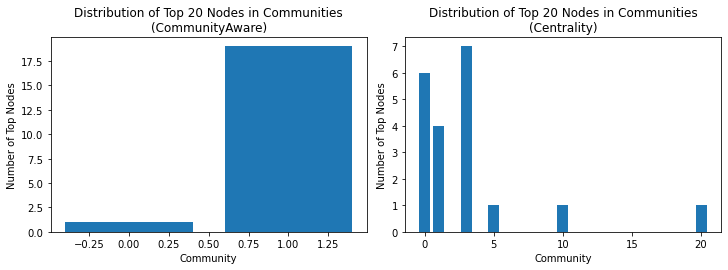

In [25]:

top = 20
community_counts = count_top_nodes_in_communities(G_edge, sorted_maps, top, partition)
plot_top_nodes_distribution(community_counts, top)

In [25]:

sorted_community_counts = count_and_sort_communities(partition)

for community, count in sorted_community_counts:
    print(f"Community {community}: {count} nodes")


Community 3: 15436 nodes
Community 1: 12485 nodes
Community 2: 8281 nodes
Community 0: 8205 nodes
Community 19: 2939 nodes
Community 5: 2371 nodes
Community 7: 1597 nodes
Community 38: 1512 nodes
Community 18: 1297 nodes
Community 127: 1228 nodes
Community 14: 809 nodes
Community 13: 781 nodes
Community 91: 748 nodes
Community 78: 741 nodes
Community 21: 701 nodes
Community 49: 700 nodes
Community 10: 636 nodes
Community 22: 588 nodes
Community 77: 565 nodes
Community 55: 548 nodes
Community 70: 528 nodes
Community 20: 527 nodes
Community 25: 520 nodes
Community 58: 508 nodes
Community 94: 492 nodes
Community 73: 473 nodes
Community 57: 473 nodes
Community 11: 461 nodes
Community 12: 454 nodes
Community 52: 440 nodes
Community 54: 370 nodes
Community 34: 369 nodes
Community 45: 351 nodes
Community 72: 351 nodes
Community 86: 343 nodes
Community 41: 338 nodes
Community 69: 335 nodes
Community 90: 335 nodes
Community 99: 329 nodes
Community 44: 320 nodes
Community 79: 307 nodes
Community

In [78]:

def leader_rank(G2, damping=0.85, tol=1e-6, max_iter=100):
    # Add the ground node connected to all other nodes
    ground_node = 'ground'
    G = G2.copy()
    G.add_node(ground_node)
    for node in set(G.nodes()) - {ground_node}:
        G.add_edge(ground_node, node)

    # Create a mapping from node to index
    node_list = list(G.nodes())
    node_index = {node: i for i, node in enumerate(node_list)}
    n = len(node_list)
    
    # Initialize scores to 1 for all nodes
    scores = np.ones(n)
    
    # Create adjacency matrix
    row = []
    col = []
    data = []
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            for neighbor in neighbors:
                row.append(node_index[neighbor])
                col.append(node_index[node])
                data.append(1.0 / len(neighbors))
    
    adjacency_matrix = csr_matrix((data, (row, col)), shape=(n, n))
    
    # Power iteration: iterate until convergence
    for _ in range(max_iter):
        new_scores = adjacency_matrix.dot(scores)
        new_scores[node_index[ground_node]] = np.sum(scores)  # Special handling for the ground node
        if np.linalg.norm(new_scores - scores, 1) < tol:
            scores = new_scores
            break
        scores = new_scores
    
    # Remove the ground node score and normalize the scores
    ground_node_score = scores[node_index[ground_node]]
    total_score = np.sum(scores) - ground_node_score
    scores = (scores - ground_node_score / n) / total_score
    
    # Create the final scores dictionary
    final_scores = {node_list[i]: scores[i] for i in range(n) if node_list[i] != ground_node}
    
    return final_scores





def calculate_h_index(G):
    h_index = {}
    for node in G.nodes():
        degrees = [G.degree(neighbor) for neighbor in G.neighbors(node)]
        degrees.sort(reverse=True)
        h = 0
        for i, degree in enumerate(degrees):
            if degree >= i + 1:
                h = i + 1
            else:
                break
        h_index[node] = h
    return h_index


In [ ]:
# Initialize an empty directed graph
# Load the .mtx file
wiki_path = '/Users/ernest/Desktop/comp8880/project/code 2/data/soc/soc-Slashdot0811.txt''
G_wiki = read_directed_graph(wiki_path,4)
# Calculate number of nodes and edges in the graph
num_nodes = G_wiki.number_of_nodes()
num_edges = G_wiki.number_of_edges()

num_nodes, num_edges

centrality = nx.degree_centrality(G_wiki)
betweenness_manual = nx.betweenness_centrality(G_wiki)
closeness_manual = nx.closeness_centrality(G_wiki)
pagerank = nx.pagerank(G_wiki, alpha=0.85, personalization=None)
leaderRank = leader_rank(G_wiki)
hIndex = calculate_h_index(G_wiki)
kShell = nx.core_number(G_wiki)

sorted_centrality = sorted(centrality.items(), key=lambda item: item[1], reverse=True)
sorted_betweenness = sorted(betweenness_manual.items(), key=lambda item: item[1], reverse=True)
sorted_closeness = sorted(closeness_manual.items(), key=lambda item: item[1], reverse=True)
sorted_pagerank =  sorted(pagerank.items(), key=lambda item: item[1], reverse=True)
sorted_leaderRank =  sorted(leaderRank.items(), key=lambda item: item[1], reverse=True)
sorted_hIndex =  sorted(hIndex.items(), key=lambda item: item[1], reverse=True)
sorted_kShell=  sorted(kShell.items(), key=lambda item: item[1], reverse=True)


print(sorted_centrality[:3])
print(sorted_betweenness[:3])
print(sorted_closeness[:3])
print(sorted_pagerank[:3])
print(sorted_leaderRank[:3])
print(sorted_hIndex[:3])
print(sorted_kShell[:3])



# 假设 sorted_centrality, sorted_betweenness 等都是已经计算好并排序的元组列表
data_to_save = {
    "Centrality": sorted_centrality,
    "Betweenness": sorted_betweenness,
    "Closeness": sorted_closeness,
    "PageRank": sorted_pagerank,
    "LeaderRank": sorted_leaderRank,
    "HIndex": sorted_hIndex,
    "KShell": sorted_kShell
}

with open('saved/network_metrics_wiki.json', 'w') as f:
    json.dump(data_to_save, f, indent=4)
